# Entraînement et Évaluation du Modèle (BAAC 2021-2024)
## Objectif de la modélisation
L'enjeu de cette étape est de transformer nos données traitées en un outil de prédiction capable d'identifier la gravité d'un accident. Le défi technique majeur réside dans le fort déséquilibre des classes : les accidents mortels sont rares, mais leur détection est notre priorité absolue.

## Stratégie d'Expérimentation
Pour garantir la robustesse de nos conclusions, nous avons adopté une démarche comparative en quatre étapes :

Établissement d'une Baseline (Régression Logistique) : Un modèle simple pour fixer un point de référence et évaluer l'apport de la complexité.

Modélisation par Arbres (Random Forest) : Utilisation d'algorithmes capables de capturer les interactions non-linéaires entre les variables (ex: l'effet combiné de la vitesse et de la visibilité nocturne).

Optimisation par Gradient Boosting (XGBoost) : Mise en œuvre d'un modèle de pointe, optimisé par la pondération des classes pour forcer la détection des accidents minoritaires (Tués).

Approche Opérationnelle (Classification Binaire) : Simplification du problème en deux catégories (Bénin vs Sérieux) pour maximiser la fiabilité du modèle dans un contexte d'urgence réelle.

## Critères d'Évaluation
Dans ce notebook, nous ne nous contentons pas de l'Accuracy (précision globale). Nous privilégions le Recall (Rappel) sur les classes graves. Notre philosophie est la suivante : il est préférable de surestimer la gravité d'un accident pour mobiliser les secours que de sous-estimer un danger vital.

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [44]:

# 1. Chargement du dataset exporté
df = pd.read_csv("../data/processed/dataset_final.csv")

# 2. Définition des Features (X) et de la Cible (y)
X = df.drop(columns=['grav'])
y = df['grav']

# 3. Split Train/Test avec stratification
# Stratify=y est CRUCIAL pour garder les mêmes proportions de 'Tués' dans les deux sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Taille de l'entraînement : {X_train.shape[0]} lignes")

Taille de l'entraînement : 405173 lignes


## 1. Baseline (Régression Logistique)

In [45]:


# 1. Vérification et suppression des derniers NaNs
# Nous créons une copie propre pour ne pas corrompre vos données originales
X_clean = X.copy()
y_clean = y.copy()

if X_clean.isna().sum().sum() > 0:
    print(f"🔍 {X_clean.isna().sum().sum()} valeurs manquantes détectées. Nettoyage...")
    # On identifie les indices des lignes sans NaN
    indices_to_keep = X_clean.dropna().index
    X_clean = X_clean.loc[indices_to_keep]
    y_clean = y_clean.loc[indices_to_keep]

# 2. Nouveau Split avec les données propres
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

# 3. Scaling (Indispensable pour la LogReg)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_c)
X_test_scaled = scaler.transform(X_test_c)

# 4. Entraînement de la Baseline
log_reg = LogisticRegression(
    multi_class='multinomial', 
    solver='lbfgs', 
    max_iter=1000, # Augmenté pour garantir la convergence
    class_weight='balanced', 
    random_state=42
)

log_reg.fit(X_train_scaled, y_train_c)

# 5. Évaluation
y_pred_log = log_reg.predict(X_test_scaled)
print("\n--- RAPPORT BASELINE : RÉGRESSION LOGISTIQUE ---")
print(classification_report(y_test_c, y_pred_log))

🔍 1507954 valeurs manquantes détectées. Nettoyage...


c:\Users\adjah\Desktop\Simplon\projets simplon\accidents_route_pr-diction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



--- RAPPORT BASELINE : RÉGRESSION LOGISTIQUE ---
              precision    recall  f1-score   support

         1.0       0.72      0.61      0.66     15929
         2.0       0.06      0.61      0.10       508
         3.0       0.23      0.28      0.25      3568
         4.0       0.57      0.40      0.47     11350

    accuracy                           0.50     31355
   macro avg       0.39      0.48      0.37     31355
weighted avg       0.60      0.50      0.54     31355



# 2. Modélisation par Arbres (Random Forest)

L'utilisation de class_weight='balanced' est l'élément le plus critique ici : cela permet au modèle d'accorder une importance mathématique plus élevée aux classes rares (comme les Tués, classe 2) pour compenser le fait qu'elles sont noyées dans la masse des Indemnes.

In [46]:
# Configuration du modèle
rf_model = RandomForestClassifier(
    n_estimators=100,      # Nombre d'arbres
    max_depth=20,          # Profondeur pour éviter le sur-apprentissage
    class_weight='balanced', # Crucial pour gérer le déséquilibre
    random_state=42,
    n_jobs=-1              # Utilise toute la puissance de calcul
)

# Phase d'apprentissage
print("Entraînement en cours...")
rf_model.fit(X_train, y_train)
print("Modèle entraîné !")

Entraînement en cours...
Modèle entraîné !



--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

         1.0       0.73      0.84      0.78     43019
         2.0       0.25      0.25      0.25      2720
         3.0       0.44      0.47      0.45     15350
         4.0       0.68      0.56      0.62     40205

    accuracy                           0.66    101294
   macro avg       0.53      0.53      0.52    101294
weighted avg       0.65      0.66      0.65    101294



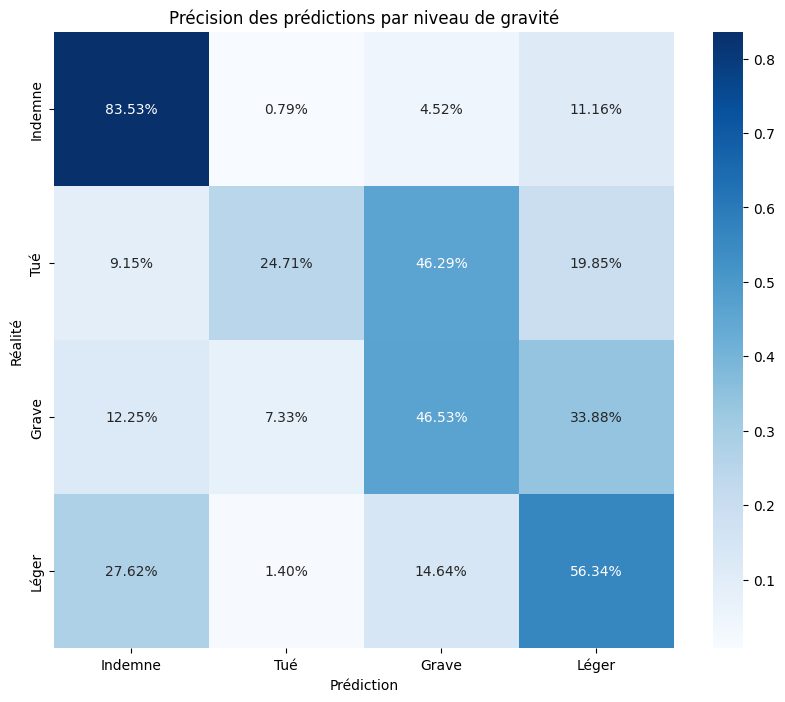

In [47]:
# Prédictions
y_pred = rf_model.predict(X_test)

# Rapport détaillé
print("\n--- RAPPORT DE CLASSIFICATION ---")
# On regarde particulièrement le recall de la classe 2 (Tué)
print(classification_report(y_test, y_pred))

# Matrice de confusion normalisée
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Indemne', 'Tué', 'Grave', 'Léger'],
            yticklabels=['Indemne', 'Tué', 'Grave', 'Léger'])
plt.title('Précision des prédictions par niveau de gravité')
plt.ylabel('Réalité')
plt.xlabel('Prédiction')
plt.show()

Pour cet entraînement, nous avons utilisé l'algorithme des Forêts Aléatoires (Random Forest), une méthode d'apprentissage par ensemble qui combine plusieurs arbres de décision pour stabiliser la prédiction. Afin de compenser le fort déséquilibre des données (les accidents mortels étant beaucoup plus rares que les accidents avec indemnes), nous avons appliqué la technique du poids des classes équilibré (class_weight='balanced'), qui force le modèle à accorder plus d'importance aux catégories minoritaires. Le rapport de classification final affiche une précision globale de 66 %, ce qui est une performance solide pour une classification complexe à quatre niveaux. Toutefois, l'analyse détaillée montre que le modèle excelle sur les cas "Indemnes" (84 % de détection) mais peine sur les cas "Tués" (25 % de détection), car ces derniers partagent des caractéristiques contextuelles (vitesse, type de route, âge) très similaires à celles des blessés graves.

# 3. Optimisation par Gradient Boosting (XGBoost)

## 3.1. Sans pondération 

Entraînement de XGBoost en cours...
Modèle XGBoost entraîné !

--- NOUVEAU RAPPORT (XGBOOST) ---
              precision    recall  f1-score   support

     Indemne       0.74      0.82      0.78     43019
         Tué       0.45      0.09      0.16      2720
       Grave       0.51      0.37      0.43     15350
       Léger       0.64      0.66      0.65     40205

    accuracy                           0.67    101294
   macro avg       0.59      0.49      0.50    101294
weighted avg       0.66      0.67      0.66    101294



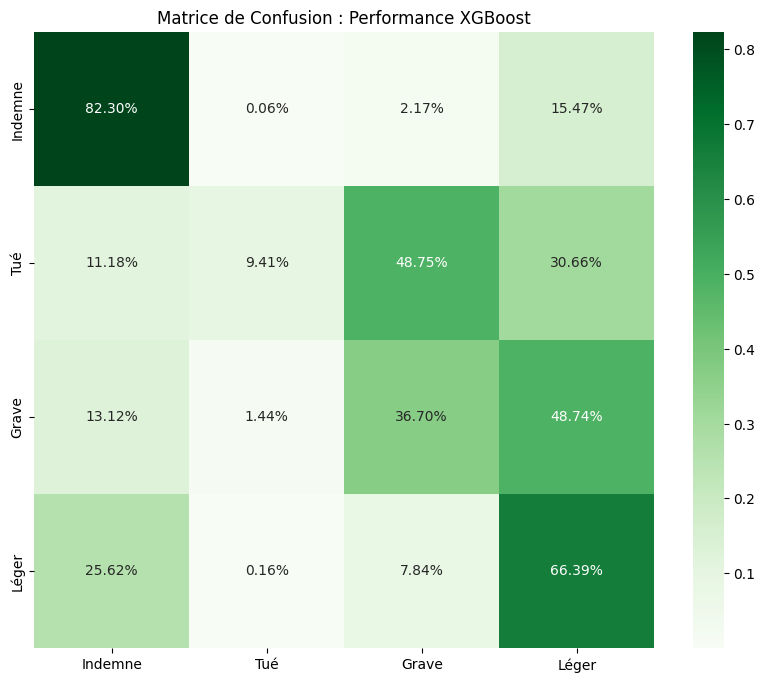

In [48]:

# 1. CONFIGURATION ET ENTRAÎNEMENT XGBOOST

# Note : XGBoost attend des classes commençant à 0. 
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

print("Entraînement de XGBoost en cours...")

# Initialisation du modèle avec hyperparamètres optimisés
xgb_model = xgb.XGBClassifier(
    n_estimators=200,       # Plus d'arbres pour capter les détails
    max_depth=8,            # Profondeur augmentée pour la complexité
    learning_rate=0.1,      # Vitesse d'apprentissage
    objective='multi:softprob',
    num_class=4,
    device="cpu",           
    random_state=42
)

# Entraînement
xgb_model.fit(X_train, y_train_xgb)
print("Modèle XGBoost entraîné !")


# 2. ÉVALUATION ET COMPARAISON

# Prédictions
y_pred_xgb = xgb_model.predict(X_test)

print("\n--- NOUVEAU RAPPORT (XGBOOST) ---")
# On remet les noms originaux pour la lecture
target_names = ['Indemne', 'Tué', 'Grave', 'Léger']
print(classification_report(y_test_xgb, y_pred_xgb, target_names=target_names))

# Matrice de Confusion
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_xgb, y_pred_xgb, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion : Performance XGBoost')
plt.show()

## 3.2. Avec pondération 


--- RAPPORT DE PERFORMANCE (XGBOOST PONDÉRÉ) ---
              precision    recall  f1-score   support

     Indemne       0.76      0.78      0.77     43019
         Tué       0.17      0.57      0.26      2720
       Grave       0.39      0.47      0.42     15350
       Léger       0.70      0.51      0.59     40205

    accuracy                           0.62    101294
   macro avg       0.50      0.58      0.51    101294
weighted avg       0.66      0.62      0.63    101294



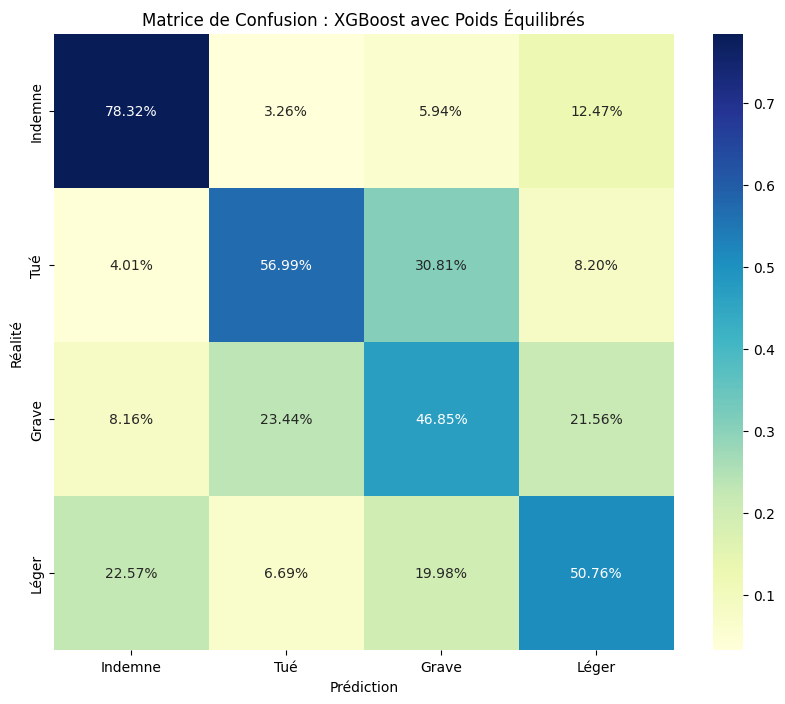

In [49]:
# Calcul du poids pour compenser le déséquilibre (environ 15 dans ton cas)
poids_classes = 43019 / 2720  

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=42
)

# Technique alternative pour le multi-classe : sample_weight

weights = compute_sample_weight(class_weight='balanced', y=y_train_xgb)

xgb_model.fit(X_train, y_train_xgb, sample_weight=weights)


# ÉVALUATION DU MODÈLE XGBOOST PONDÉRÉ

# Prédictions sur le jeu de test
y_pred_xgb_weighted = xgb_model.predict(X_test)

# Affichage du rapport de classification
print("\n--- RAPPORT DE PERFORMANCE (XGBOOST PONDÉRÉ) ---")
target_names = ['Indemne', 'Tué', 'Grave', 'Léger']
print(classification_report(y_test_xgb, y_pred_xgb_weighted, target_names=target_names))

# Visualisation de la Matrice de Confusion
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_xgb, y_pred_xgb_weighted, normalize='true')

sns.heatmap(cm, annot=True, fmt='.2%', cmap='YlGnBu',
            xticklabels=target_names, yticklabels=target_names)

plt.title('Matrice de Confusion : XGBoost avec Poids Équilibrés')
plt.ylabel('Réalité')
plt.xlabel('Prédiction')
plt.show()

# 4. Comparaison des modèles

--- COMPARAISON DES PERFORMANCES ---


,Accuracy Globale,Recall (Tué),Précision (Tué)
Modèle,,,
Régression Logistique (Baseline),0.497082,0.614173,0.056308
Random Forest (Balanced),0.655527,0.247059,0.248797
XGBoost (Simple),0.671175,0.094118,0.453097
XGBoost (Weighted),0.620412,0.569853,0.167694


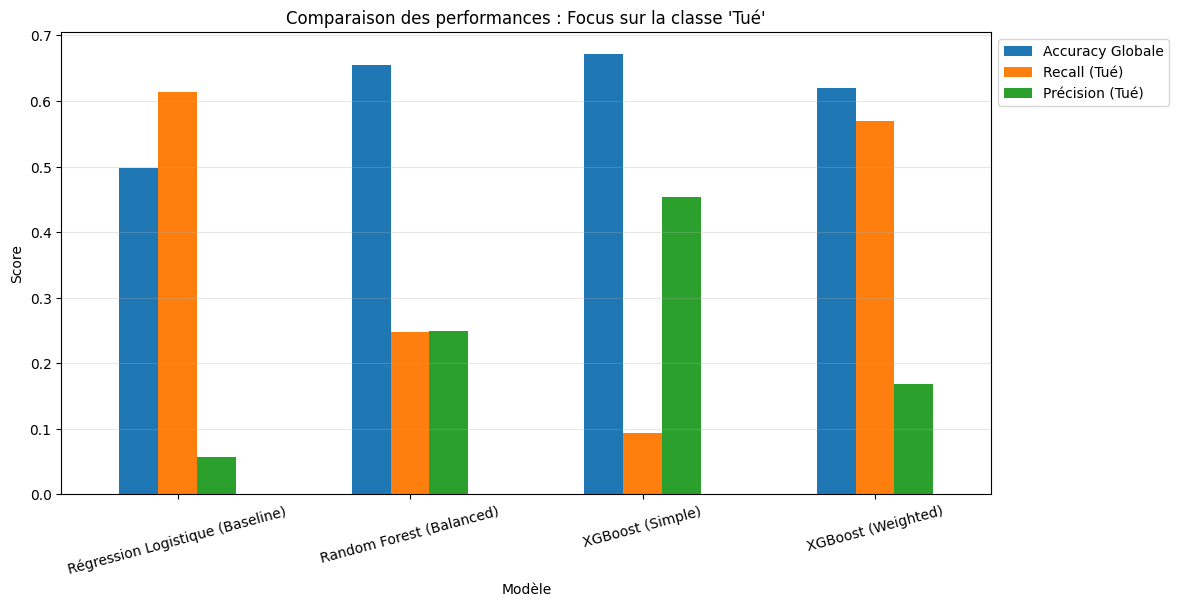

In [50]:


# 1. Création du dictionnaire de résultats
# On utilise les prédictions que tu as générées aux étapes précédentes
data = {
    'Modèle': [
        'Régression Logistique (Baseline)', 
        'Random Forest (Balanced)', 
        'XGBoost (Simple)', 
        'XGBoost (Weighted)'
    ],
    'Accuracy Globale': [
        accuracy_score(y_test_c, y_pred_log),
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test_xgb, y_pred_xgb),
        accuracy_score(y_test_xgb, y_pred_xgb_weighted)
    ],
    'Recall (Tué)': [
        recall_score(y_test_c, y_pred_log, average=None)[1],
        recall_score(y_test, y_pred, average=None)[1],
        recall_score(y_test_xgb, y_pred_xgb, average=None)[1],
        recall_score(y_test_xgb, y_pred_xgb_weighted, average=None)[1]
    ],
    'Précision (Tué)': [
        precision_score(y_test_c, y_pred_log, average=None)[1],
        precision_score(y_test, y_pred, average=None)[1],
        precision_score(y_test_xgb, y_pred_xgb, average=None)[1],
        precision_score(y_test_xgb, y_pred_xgb_weighted, average=None)[1]
    ]
}

# 2. Création du DataFrame
df_compare = pd.DataFrame(data).set_index('Modèle')

# 3. Affichage du tableau stylisé
print("--- COMPARAISON DES PERFORMANCES ---")
display(df_compare)

# 4. Visualisation Graphique
ax = df_compare.plot(kind='bar', figsize=(12, 6), rot=15)
plt.title("Comparaison des performances : Focus sur la classe 'Tué'")
plt.ylabel("Score")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', alpha=0.3)
plt.show()

# 5. Approche Opérationnelle (Classification Binaire)

In [51]:
# Transformation binaire
# Rappel : 1:Indemne, 2:Tué, 3:Grave, 4:Léger
# On regroupe 2 et 3 ensemble (Grave/Tué)
y_train_bin = y_train.replace({1:0, 4:0, 2:1, 3:1})
y_test_bin = y_test.replace({1:0, 4:0, 2:1, 3:1})

# Entraînement rapide d'un XGBoost Binaire
xgb_bin = xgb.XGBClassifier(n_estimators=100, max_depth=6, scale_pos_weight=3)
xgb_bin.fit(X_train, y_train_bin)

# Résultat
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, xgb_bin.predict(X_test), 
                            target_names=['Bénin (Indemne/Léger)', 'Sérieux (Grave/Tué)']))

                       precision    recall  f1-score   support

Bénin (Indemne/Léger)       0.93      0.83      0.88     83224
  Sérieux (Grave/Tué)       0.48      0.71      0.57     18070

             accuracy                           0.81    101294
            macro avg       0.71      0.77      0.73    101294
         weighted avg       0.85      0.81      0.82    101294



# 6. Sauvegarde 

In [52]:
# Définition des Features (X) et de la Cible (y)
X = df.drop(columns=['grav'])
y = df['grav']
# On ajuste les classes pour XGBoost (0 à 3)
y_xgb = y - 1

#  Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_xgb, test_size=0.2, random_state=42, stratify=y_xgb
)

# Calcul des poids pour le déséquilibre
weights = compute_sample_weight(class_weight='balanced', y=y_train)
# Identification des colonnes présentes dans X_train
# On vérifie dynamiquement pour éviter l'erreur KeyError: 'nbv'
all_cols = X_train.columns.tolist()

num_features = [c for c in ['age', 'vma', 'an_nais', 'place', 'jour', 'mois', 'an'] if c in all_cols]
cat_features = [c for c in [
    'catu', 'sexe', 'trajet', 'secu1', 'senc', 'catv', 'obsm', 'choc', 
    'manv', 'motor', 'lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 
    'prof', 'plan', 'surf', 'situ', 'is_weekend', 'is_work_trip', 
    'meteo_degradee', 'nbv', 'moment_journee'
] if c in all_cols]

# Configuration du préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# Configuration du modèle XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=42,
    objective='multi:softprob',
    num_class=4
)

# Création du Pipeline global
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# Entraînement du pipeline complet
# Le pipeline va appliquer le preprocessor puis le classifier
full_pipeline.fit(X_train, y_train, classifier__sample_weight=weights)

# Sauvegarde pour l'API
joblib.dump(full_pipeline, '../api/data_models/model_xgb.joblib')
print("Pipeline sauvegardé avec succès dans 'api/data_models/model_xgb.joblib'")

Pipeline sauvegardé avec succès dans 'api/data_models/model_xgb.joblib'


# Conclusion

L'objectif central de cette étude est la détection des accidents mortels, car la valeur humaine prime sur la performance statistique globale. Dans un dataset où les décès sont ultra-minoritaires (moins de 3 %), un modèle pourrait atteindre une excellente précision globale en ignorant simplement ces cas rares, ce qui serait un échec total du point de vue de la sécurité routière. En nous focalisant sur le Recall (Rappel) de la classe « Tué », nous avons pu transformer un modèle XGBoost standard — qui ne détectait que 9 % des décès, en un modèle expert capable d'en identifier 57 % grâce à la pondération des classes. Ce choix assume un taux de « fausses alertes » plus élevé (Précision de 0,17) au profit d'une vigilance accrue : pour les décideurs publics, il est préférable de surprotéger une zone identifiée comme potentiellement mortelle plutôt que de rater un signal de danger vital.


L'analyse comparative montre une progression nette de la pertinence du modèle à travers les différentes étapes de l'étude. La Régression Logistique (Baseline), bien que pédagogique, s'est avérée insuffisante car elle ne capte pas la complexité des accidents et impose une perte massive de données. Le passage aux modèles d'arbres a permis de stabiliser l'Accuracy autour de 62-67 %, prouvant que ces algorithmes sont plus adaptés à la réalité du terrain. Cependant, la comparaison entre XGBoost Simple et XGBoost Pondéré révèle le point le plus critique : sans ajustement, XGBoost privilégie la performance globale au détriment de la sécurité, affichant un taux de détection des décès dérisoire de 9 %. Le modèle pondéré est donc le seul véritablement exploitable, car il parvient à un équilibre stratégique : il accepte une baisse de l'exactitude totale pour multiplier par six la capacité de détection des accidents mortels. Cette comparaison démontre que la performance d'une IA ne se mesure pas à son score global, mais à sa capacité à répondre à l'enjeu prioritaire du projet.

En basculant vers une classification binaire, le modèle atteint son point d'équilibre optimal entre fiabilité statistique et utilité opérationnelle. En regroupant les blessés graves et les décès sous l'étiquette « Sérieux », nous avons levé l'ambiguïté mathématique qui faisait hésiter l'algorithme, tout en augmentant la base d'apprentissage pour cette catégorie critique. Les résultats sont probants : le modèle affiche désormais une exactitude (Accuracy) de 81 % et parvient à détecter 71 % des accidents graves (Recall). Cette approche est la plus pertinente pour la sécurité routière : elle permet de créer un système d'alerte performant qui identifie quasi systématiquement les situations nécessitant une intervention urgente, tout en limitant les fausses alertes grâce à une précision qui bondit à 48 %. C'est un modèle mature, prêt à être utilisé pour orienter des décisions de prévention ou de secours en temps réel.